# IAAV - Laborator #4
# Rețele Neurale Convoluționale

## Introducere

În primul laborator am văzut cum un model liniar simplu a obținut o acuratețe de 91% în clasificarea cifrelor scrise manual din setul de date MNIST.

În acest laborator vom implementa în TensorFlow o Rețea Neurală Convoluțională simplă care are o acuratețe de aproximativ 99%, sau chiar mai mult (în urma rezolvării exercițiilor propuse).

Rețelele Neurale Convoluționale funcționează prin glisarea unor mici filtre de-a lungul imaginii de input. Asta înseamnă că filtrele sunt reutilizate pentru recunoașterea unor șabloane în imaginea dată. Asta face Rețeaua Neurală Convoluțională mai puternică decât una tradițională, Fully-Connected, cu același număr de parametri învățabili, și, de asemenea, mai rapid de antrenat.


Schema de mai jos arată, în linii mari, modul în care fluxul de date se desfășoară în Rețeaua Neurală Convoluțională implementată mai jos.

![Flowchart](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/02_network_flowchart.png?raw=1)

Imaginea de input este procesată în primul strat convoluțional folosind filtrele învățabile (Filter-Weights). Rezultă 16 `imagini` noi, câte una pentru fiecare filtru din stratul convoluțional. Imaginile sunt, de asemenea, micșorate, astfel că rezoluția este redusă de la 28x28 pixeli la 14x14 pixeli

Cele 16 imagini mai mici sunt apoi processate în cel de-al doilea strat convoluțioal. Avem nevoie de filtre pentru fiecare dintre cele 16 canale, și avem nevoie și de filtre pentru fiecare canal rezultat din acest strat. Există 36 de canale în rezultat, deci există un total de `36 x 16 = 576` filtre în cel de-al doilea strat convoluțional. Imaginile rezultate sunt reduse din nou, la 7x7 pixeli.

Rezultatul celui de-al doilea strat convoluțional constă în 36 de imagini de 7x7 pixeli fiecare. Acestea sunt apoi aplatizate într-un singur vector de lungime `7 x 7 x 36 = 1764`, care este folosit ca input pentru un strat fully-connected cu 128 de neuroni. Aceste este conectat la un alt strat fully-connected cu 10 neuroni, câte unul pentru fiecare clasă, reprezentând numărul din imaginea dată.

Filtrele convoluționale sunt initializate aleatoriu. Eroarea dintre clasa prezisă și cea reală este măsurată cu ajutorul cross-entropy. Optimizatorul propagă apoi această eroare înapoi prin rețea folosind regula înlănțuirii pentru calculul gradienților și actualizează parametrii învățabili ai rețelei pentru a îmbunătăți eroarea de clasificare. Acesta este un proces iterativ, până când eroarea de clasificare este suficient de mică.

Rețineți că optimizarea în TensorFlow nu se realizează pe o singură imagine, ci pe un subset de imagini, calculele realizându-se, astfel, mult mai eficient. Asta înseamnă că în TensorFlow, datele au, de fapt, mai multe dimensiuni decât în reprezentarea de mai sus.


## Stratul Convoluțional

Schema de mai jos prezintă conceptul de bază al procesării unei imagini în primul strat convoluțional. Imaginea de input reprezintă numărul `7` și patru copii ale sale sunt afișate, pentru a vedea mai clar modul în care filtrul este mutat în diferite poziții ale imaginii. Pentru fiecare poziție a filtrului, se calculează produsul scalar între filtru și pixelii din imagine de sub filtru și rezultă un singur pixel în imaginea de output. Deci, mutarea filtrului de-a lungul întregii imagini de input are ca rezultat o nouă imagine.

Valorile roșii semnifică faptul că filtrul are o reacție pozitivă la pixelii negri din imaginea de input, în timp ce pixelii albaștri semnifică faptul că filtrul are o reacție negativă la pixelii negri.

În acest caz se pare că filtrul recunoaște linia orizontală a cifrei `7`, după cum se poate vedea din reacția sa mai puternică la acea linie în imaginea rezultată.

![Convolution example](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/02_convolution.png?raw=1)

Pasul cu care se deplasează filtrul de-a lungul imaginii se numește **stride**. Există un stride pentru a muta filtrul pe axa orizontală (axa x) și un alt stride pentru a-l muta pe axa verticală (axa y).

Noi vom setea `stride = 1` pentru ambele direcții, ceea ce înseamnă că filtrul este aplicat din colțul stânga-sus al imaginii și este mutat la dreapta cu 1 pixel la fiecare pas. Când filtrul ajunge la capătul dreapta al imaginii, este mutat înapoi la capătul din stânga și mai jos cu 1 pixel. Procesul continuă până când filtrul ajunge în colțul din dreapta jos al imagii și întreaga imagine de output a fost generată.

Pentru ca imaginea de output să aibă aceeași dimensiune cu cea de input, se aplică `zero-padding` peste imaginea inițială.

Mai mult, peste rezultatul convoluției se aplică ReLU, care asigură doar că rezultatul este non-negativ, prin înlocuirea valorilor negative cu zero. Rezultatul poate, de asemenea, să fie micșorat, prin `max-pooling`, care se aplică pe ferestre mici din output (2 x 2) și păstrează doar pixelul cu valoarea maximă. Acest lucru înjumătățește rezoluția imaginii.

Observați că cel de-al doilea strat convoluțional este mai complicat, deoarece primește 16 canale ca input. Dorim un filtru separat pentru fiecare canal din input, deci avem nevoie de 16 filtre în loc de unul singur. În plus, dorim 36 de canale la ieșirea celui de-al doilea strat convoluțional, deci avem nevoie, în total, de `16 x 36 = 576` de filtre pentru cel de-al doilea strat convoluțional.

## Imports

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

Vizualizare versiune TensorFlow

In [985]:
tf.__version__

'1.13.1'

## Configurația Rețelei Neurale Convoluționale

Definim aici configurația Rețelei Neurale Convoluționale pentru comodidate, astfel încât aceste valori să poată fi găsite și modificate ușor.

In [0]:

# Primul strat convoluțional.
filter_size1 = 5          # Filtrele convoluționale au dimensiune 5 x 5 pixeli.
num_filters1 = 16         # Sunt 16 filtre.

# Al 2-lea strat convoluțional.
filter_size2 = 5          # Filtrele convoluționale au dimensiune 5 x 5 pixeli.
num_filters2 = 36         # Sunt 36 de filtre. 

# Stratul fully-connected.
fc_size = 128             # Numărul de neuroni în stratul fully-connected.

## Load Data

In [0]:
mnist = tf.keras.datasets.mnist

Setul de date MNIST conține 70.000 de imagini și adnotări (clase) pentru imagini. Imaginile sunt împărțite în 2 subseturi mutual exclusive, unul folosit pentru antrenare iar celălalt pentru testare.

In [988]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

print("Dimensiunea:")
print("- Setului de antrenare:\t\t{}".format(y_train.shape[0]))
print("- Setului de test:\t\t{}".format(y_test.shape[0]))
print("- Unei imagini:\t\t\t{}".format(x_train.shape[1:]))

Dimensiunea:
- Setului de antrenare:		60000
- Setului de test:		10000
- Unei imagini:			(28, 28)


In [0]:
# Dimensiunea axei unei imagini.
img_size = x_train.shape[1]

# Dimensiunea setului de antrenare.
num_images = x_train.shape[0]

# Dimensiunea unei imagini.
img_shape = x_train.shape[1:]

# Numărul de clase.
num_classes = np.unique(y_train).size

# numărul de canale: 1 pentru imagini grayscale.
num_channels = 1

### Encodarea One-Hot

Clasele imaginilor sunt reprezentate de întregi, fiecare număr întreg semnificând indexul unei clase. În probleme de clasificare, însă, este nevoie ca valorile claselor să fie encodate One-Hot, adică fiecare întreg este convertit într-un vector a cărui lungime este egală cu numărul de clase. Toate elementele vectorului sunt 0 cu excepția elementului $i$ care este 1, semnificând faptul că exemplul respectiv aparține clasei $i$.

In [0]:
y_train_one_hot = np.eye(num_classes)[y_train]
y_test_one_hot = np.eye(num_classes)[y_test]


### Funcții ajutătoare pentru afișarea imaginilor

Funcție pentru afișarea a 9 imagini într-un grid 3x3 și a claselor corecte și a celor prezise pentru fiecare imagine

In [0]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### Afișează câteva imagini pentru a verifica corectitudinea datelor

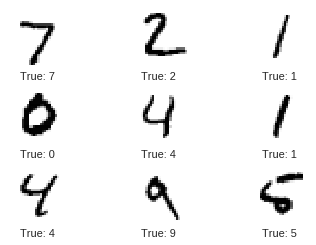

In [992]:
# Obține primele imagini din setul de test.
images = x_test[0:9]

# Obține clasele reale pentru acele imagini.
cls_true = y_test[0:9]

# Afișează imaginile.
plot_images(images=images, cls_true=cls_true)

## [Graful TensorFlow](https://www.tensorflow.org/guide/graphs)

Scopul general al TensorFlow este de a avea un așa-numit graf computațional care poate fi executat mult mai eficient decât dacă aceleași operații ar fi executate direct în Python. TensorFlow poate fi mai eficient și decât [NumPy](http://www.numpy.org/) pentru că TensorFlow cunoaște întregul graf computațional care trebuie executat, în timp ce NumPy cunoaște doar o singură operație matematică la un moment dat.

TensorFlow poate, de asemenea, să calculeze automat gradienții necesari pentru optimizarea variabilelor grafului, astfel încât modelul să performeze mai bine. Acest lucru se datorează faptului că graful este o combinație de expresii matematice simple, astfel că gradientul întregului graf poate fi calculat folosind regula înlănțuirii pentru derivate.

TensorFlow poate, de asemenea, să beneficieze de avantajul arhitecturilor multi-CPU și GPU iar Google chiar a construit arhitecturi speciale pentru TensorFlow ([TPU](https://cloud.google.com/tpu/) - Tensor Processing Units) care sunt chiar mai rapide decât GPU-urile.

Un graf TensorFlow conține următoarele părți:

* variabile de tip [Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)  folosite pentru a specifica input-ul în graf.
* [variabilele modelului](https://www.tensorflow.org/guide/variables) care vor fi optimizate pentru a face modelul să performeze mai bine.
* modelul care este, în esență, doar o funcție matematică care calculează un rezultat pe baza input-ului din variabilele placeholder și a variabilelor modelului.
* o [funcție de cost](https://www.tensorflow.org/api_docs/python/tf/losses) folosită pentru a "ghida" optimizarea variabilelor.
* o [metodă de optimizare](https://www.tensorflow.org/api_docs/python/tf/train) care actualizează variabilele modelului.

În plus, graful TensorFlow mai poate conține diverse informații pentru debug, care pot fi afișate în [TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard).

### Funcții ajutătoare pentru crearea de noi variablie.

Funcții pentru crearea de noi variabile TensorFlow de dimensiune dată și inițializate aleatoriu.


In [0]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [0]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Funcție ajutătoare pentru crearea unui nou strat convoluțional.

Această funcție creează un nou strat convoluțional în graful TensorFlow. Nimic nu este calculat în acest moment, ci doar se adaugă operațiile matematice în graf.

Presupunem că inputul este un tensor 4-dimensional, cu următoarele dimensiuni:

1. batch_size.
2. înălțime imagini.
3. lățime imagini.
4. canale imagini.

Rezultatul este un alt tensor 4-dimensional, cu următoarele dimensiuni:

1. batch_size, la fel ca input.
2. înălțime imagini. Dacă a fost folosit pooling 2x2, atunci înălțimea imaginii de input este înjumătățită.
3. lățime imagini. Dacă a fost folosit pooling 2x2, atunci înălțimea imaginii de input este înjumătățită.
4. canale produse de filtrele convoluționale.

In [0]:
def new_conv_layer(input,              # Stratul anterior.
                   num_input_channels, # Nr. canale în stratul anterior.
                   filter_size,        # Înălțimea și lățimea fiecărui filtru.
                   num_filters,        # Nr. de filtre.
                   use_pooling=True):  # Aplică max-pooling 2x2.

    # Forma filtrelor convoluționale.
    # Formatul este stabilit de API-ul TensorFlow.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Creează ponderi noi (filtre de forma dată).
    weights = new_weights(shape=shape)

    # Creează noi bias-uri, unul pentru fiecare filtru
    biases = new_biases(length=num_filters)

    # Creează operația TensorFlow pentru convoluție.
    # Observați că stride=1 pentru toate axele.
    # Primul și ultimul stride sunt întotdeauna 1,
    # pentru că prima dimensiune reprezintă batch_size-ul,
    # iar ultima este numărul de canale în input.
    # strides=[1, 2, 2, 1] semnifică faptul că filtrele sunt
    # mutate 2 pixeli de-a lungul axelor x și y ale imaginilor.
    # Padding este 'SAME', ceea ce înseamnă că la imaginea de input
    # sunt adăugate zerouri astfel încât dimensiunea imaginii rezultate
    # rămâne la fel.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Adaugă bias-urile la rezultatul convoluției.
    # Se adaugă câte un bias la fiecare filru.
    layer += biases

    # Folosește pooling pentru a micșora imaginea?
    if use_pooling:
        # Folosește max-pooling 2x2, ceea ce înseamnă că
        # ia în considerare ferestre de dimensiune 2x2 și 
        # păstrează cea mai mare valoare din fiecare fereastră.
        # Apoi ne mutăm 2 pixeli în fereastra următoare.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # Calculează max(0, x) pentru fiecare pixel x din input.
    # Asta adaugă neliniaritate în rețea și permite învățarea
    # unor șabloane mai complicate în imagini.
    layer = tf.nn.relu(layer)

    # În mod normal, ReLU se execută înaintea pooling,
    # dar pentru că relu(max_pool(x)) == max_pool(relu(x)),
    # putem obține cu 75% mai puțin operații relu dacă
    # executăm mai întâi max-pooling.

    # Returnează atât stratul rezultat, cât și ponderile filtrelor,
    # deoarece vom afișa aceste ponderi mai târziu.
    return layer, weights

### Funcție ajutătoare pentru aplatizarea unui strat

Un strat convoluțional produce un tensor cu 4 dimensiuni. Pentru a adăuga un strat fully-connected după cele convoluționale, trebuie să reducem tensor-ul 4-dimensional la unul cu 2 dimensiuni, care poate fi folosit ca input în stratul fully-connected.

In [0]:
def flatten_layer(layer):
    # Obține forma stratului de input.
    layer_shape = layer.get_shape()

    # Presupunem că stratul de input este de forma:
    # layer_shape == [batch_size, img_height, img_width, num_channels]

    # Numărul de elemente într-un filtru: img_height * img_width * num_channels
    num_features = layer_shape[1:4].num_elements()
    
    # Redimensionăm stratul pentru a fi [num_images, num_features]
    # Observați că doar setăm dimensiunea celei de-a doua axe
    # la num_features și dimensiunea primei axe la -1, ceea ce înseamnă
    # că dimensiunea acelei axe este calculată astfel încât dimensiunea
    # totală a tensor-ului rămâne neschimbată.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # Noul strat are acum forma:
    # [batch_size, img_height * img_width * num_channels]

    # Returnează atât stratul aplatizat, cât și numărul de features.
    return layer_flat, num_features

### Funcție ajutătoare pentru crearea unui strat fully-connected.

Această funcție creează un nou strat fully-connected în graful computațional TensorFlow. Nimic nu este calculat în acest moment, doar se adaugă operațiile matematice în graf.

Presupunem că input-ul este un tensor 2D de forma `[batch_size, num_inputs]`. Output-ul este un tensor de forma `[batch_size, num_outputs]`.

In [0]:
def new_fc_layer(input,          # Stratul anterior.
                 num_inputs,     # Nr. neuroni în stratul anterior.
                 num_outputs,    # Nr. neuroni.
                 use_relu=True): # Folosește Rectified Linear Unit (ReLU)?

    # Creează noi ponderi și bias.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Definește stratul ca înmulțirea matriceală dintre
    # input și ponderi, apoi adaugă bias-urile.
    layer = tf.matmul(input, weights) + biases

    # Folosește ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

### [Variabile Placeholder](https://www.tensorflow.org/api_docs/python/tf/placeholder)

Variabilele Placeholder servesc ca input în graf și pot fi schimbate de fiecare dată când executăm graful. 

Mai întâi definim variabila Placeholder pentru imaginile de input. Asta ne permite să schimbăm imaginile pe care le vom trimite grafului TensorFlow. Aceasta este un așa-numit [tensor](https://en.wikipedia.org/wiki/Tensor) care este doar un vector multi-dimensional sau o matrice. Tipul de date este `float32` iar forma tensorului este `[None, img_size, img_size, num_channels]`, unde `None` semnifică faptul că tensorul poate conține un număr arbitrar de imagini.

In [0]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

În continuare definim variabila placeholder pentru clasele corecte encodate one-hot, asociate imaginilor date ca input în variabila `x` definită anterior. Forma acestui tensor este `[None, num_classes]`, semnificând faptul că poate conține un număr arbitrar de exemple, fiecare fiind un vector de lungime `num_classes`, care este 10 în acest caz.

In [0]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

Folosim `argmax` pentru a obține clasa fiecărei imagini.

In [0]:
y_true_cls = tf.argmax(y_true, axis=1)

### Primul strat convoluțional

Creează primul strat convoluțional. Primește `x_image` ca input și creeazp `num_filters1` filtre diferite, fiecare având înălțimea și lățimea egale cu `filter_size1`. În final, dorim să micșorăm imaginea la jumătate din dimensiunea inițială, folosind max-pooling 2x2.

In [0]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=False)

Verifică dimensiuna tensorului rezultat în urma convoluției. Ar trebui să fie (?, 14, 14, 16), semnificând faptul că există un număr arbitrar de imagini, fiecare de dimensiune 14x14, și sunt 16 canale diferite, un canal pentru fiecare filtru.

In [1002]:
layer_conv1

<tf.Tensor 'Relu_50:0' shape=(?, 28, 28, 16) dtype=float32>

### Al 2-lea strat convoluțional

Creează cel de-al 2-lea strat convoluțional, care primește ca input rezultatul primului strat convoluțional. Numărul de canale din input corespunde numărului de filtre din primul strat convoluțional.

In [0]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=False)

Verifică dimensiuna tensorului rezultat în urma convoluției. Ar trebui să fie (?, 7, 7, 36), semnificând faptul că există un număr arbitrar de imagini, fiecare de dimensiune 7x7, și sunt 36 canale diferite, un canal pentru fiecare filtru.

In [1004]:
layer_conv2

<tf.Tensor 'Relu_51:0' shape=(?, 28, 28, 36) dtype=float32>

Rezultatul celui de-al 2-lea strat convoluțional este un tensor 4D. Vrem acum să-l folosim ca input într-un strat fully-connected, ceea ce necesită redimensionarea sa într-un tensor 2D.

In [0]:
layer_flat, num_features = flatten_layer(layer_conv2)

Verifică dimensiunea tensorului aplatizat, care ar trebui să fie (?, 1764), ceea ce înseamnă că există un număr arbitrar de imagini, care au fost transformate în vectori de dimensiune 1764 fiecare (7 x 7 x 36 = 1764).

In [1006]:
layer_flat

<tf.Tensor 'Reshape_34:0' shape=(?, 28224) dtype=float32>

In [1007]:
num_features

28224

### Primul strat fully-connected

Adaugă un strat fully-connected în rețea. Input este tensorul aplatizat obținut în urma convoluției anterioare. Numărul de neuroni în stratul fully-connected este `fc_size`. Se aplică ReLU pentru a învăța relații ne-liniare.

In [0]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

Verifică dimensiunea tensorului rezultat în urma stratului fully-connected, care ar trebui să fie (?, 128), unde ? înseamnă că există un număr arbitrar de imagini, iar `fc_size` == 128.

In [1009]:
layer_fc1

<tf.Tensor 'Relu_52:0' shape=(?, 128) dtype=float32>

### Cel de-al 2-lea strat fully-connected

Adaugă încă un strat fully-connected care scoate vectori de lungime 10, pentru a determina cărei clase din cele 10 aparține imaginea de input. Observați că după acest strat nu se aplică ReLU.

In [0]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [1011]:
layer_fc2

<tf.Tensor 'add_70:0' shape=(?, 10) dtype=float32>

### Clasa prezisă

Cel de-al 2-lea strat fully-connected evaluează probabilitatea ca imaginea de input să aparțină fiecăreia din cele 10 clase. Cu toate acestea, aceste estimări sunt dificil de interpretat pentru că numerele pot fi foarte mici sau foarte mari, așa că dorim să le normalizăm astfel încât fiecare element este limitat între 0 și 1, iar suma lor este 1. Pentru aceasta folosim funcția `softmax`, iar rezultatul este păstrat în `y_pred`.

In [0]:
y_pred = tf.nn.softmax(layer_fc2)

Clasa prezisă poate fi calculată din `y_pred` prin obținerea indexului elementului maxim de pe fiecare rând.

In [0]:
y_pred_cls = tf.argmax(y_pred, axis=1)

### Funcția de cost

Pentru a îmbunătăți modelul în clasificarea imaginilor de input, trebuie să modificăm cumva ponderile tuturor straturilor rețelei. Pentru a realiza asta, trebuie să știm cât de bine performează modelul, comparând rezultatul prezis de model `y_pred` cu valorile corecte `y_true`.

[`cross-entropy`](https://en.wikipedia.org/wiki/Cross_entropy) este o măsură a performanței utilizată în clasificare. Este o funcție continuă, pozitivă tot timpul și dacă rezultatele prezise de model se potrivesc exact cu rezultatele corecte, atunci valoarea cross-entropy este 0. Scopul optimizării este, astfel, minimizarea valorii cross-entropy, să tindă către 0 prin modificarea ponderilor straturilor rețelei.

TensorFlow conține o funcție pentru calcularea cross-entropy. Observați că folosește valorile din `layer_fc2` pentru că intern calculează și `softmax`.

In [0]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

Acum am calculat cross-entropy pentru fiecare clasificare de imagine, astfel că avem o măsură a cât de bine performează modelul pe fiecare imagine în parte. Dar pentru a folosi cross-entropy pentru a "ghida" optimizarea variabilelor modelului, avem nevoie de o singură valoare scalară, astfel că pur și simplu vom calcula media valorilor cross-entropy pentru toate clasificările făcute.

In [0]:
cost = tf.reduce_mean(cross_entropy)

### Metoda de optimizare

Acum că avem o măsură a costului care trebuie minimizat, putem defini un optimizator. În acest caz vom folosi [AdamOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/AdamOptimizer), care este o variantă avansată a Gradient Descent.

Observați că optimizarea nu se execută în acest past. De fapt, nimic nu este calculat până acum, operațiile doar au fost adaugate în graful TensorFlow pentru a fi executate mai târziu.

In [0]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Măsuri ale performanței

Avem nevoie de câteva măsuri de performanță pentru a fi afișate utilizatorului.

Acesta este un vector de `bool` care specifică dacă clasa prezisă coincide cu cea reală.

In [0]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

Aceasta calculează acuratețea clasificării, prin convertirea vectorului la float, astfel că False devine 0, iar True devine 1, după care se calculează media acestor numere.

In [0]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow Run

### Creează Sesiunea TensorFlow

După ce graful TensorFlow a fost finalizat, trebuie să creăm o sesiune TensorFlow pentru a executa graful.

In [0]:
session = tf.Session()

### Inițializează variabilele

Variabilele `weights` și `biases` trebuie inițializate înainte de a le optimiza.

In [0]:
session.run(tf.global_variables_initializer())

### Funcție ajutătoare pentru a realiza optimizarea

Sunt 60.000 de imagini în setul de antrenare, astfel că durează mult să calculăm gradientul modelului folosind întreg setul. Așadar vom folosi doar un mic subset de imagini la fiecare iterație a optimizatorului.

In [0]:
train_batch_size = 64

Funcție pentru a realiza un număr de iterații de optimizare astfel încât să îmbunătățim gradual ponderile rețelei. În fiecare iterație, un nou subset de imagini este selectat din setul de antrenare iar TensorFlow execută optimizarea folosind sub-setul respectiv. Progresul este afișat după fiecare 100 de iterații.

In [0]:
# Numărul total de iterații executate până acum.
total_iterations = 0

indices = np.arange(num_images)

def optimize(num_iterations):
    # Ne asigurăm că actualizăm variabila globală și nu o copie locală.
    global total_iterations

    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Obține un subset de exemple de antrenare
        # x_batch conține subsetul de imagini
        # y_true_batch conține subsetul de clase.
        batch_indices = np.random.choice(indices, train_batch_size)
        x_batch = x_train[batch_indices]
        y_true_batch = y_train_one_hot[batch_indices]

        # Pune subsetul de imagini și clase într-un dicționar
        # cu numele corespunzătoare pentru variabilele placeholder
        # din graful TensorFlow.
        # Observați că placeholderul y_true_cls nu este adăugat
        # în dicționar pentru că nu este folosit în timpul antrenării.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Execută optimizatorul folosind acest subset de exemple.
        # TensorFlow asignează variabilele din dicționarul 
        # feed_dict_train placeholder-elor după care execută optimizatorul.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Afișează progresul la fiecare 100 de iterații.
        if i % 100 == 0:
            # Calculează acuratețea pe setul de antrenare.
            acc = session.run(accuracy, feed_dict=feed_dict_train)


            msg = "Iter: {0:>6}, Training Accuracy: {1:>6.1%}"

            print(msg.format(i + 1, acc))

    # Actualizează numărul total de iterații executate.
    total_iterations += num_iterations

    end_time = time.time()
    time_dif = end_time - start_time

    print("Time: " + str(timedelta(seconds=int(round(time_dif)))))

### Funcție ajutătoare pentru afișarea exemplelor greșite

In [0]:
def plot_example_errors(cls_pred, correct):
    incorrect = (correct == False)
    
    # Obține imaginile clasificate greșit.
    images = x_test[incorrect]
    
    # Obține clasele prezise pentru aceste imagini.
    cls_pred = cls_pred[incorrect]

    # Obține clasele corecte pentru aceste imagini.
    cls_true = y_test[incorrect]
    
    # Afișează primele 9 imagini.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Funcție pentru afișarea matricei de confuzie

In [0]:
def plot_confusion_matrix(cls_pred):
  
    # Obține clasele prezise pentru setul de test.
    cls_true = y_test
    
    # Obține matricea de confuzie.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Printează matricea de confuzie.
    print(cm)

    # Afișează matricea de confuzie sub formă de imagine.
    plt.matshow(cm)

    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()

### Funcție ajutătoare pentru afișarea performanței

In [0]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Numărul de imagini în setul de test.
    num_test = x_test.shape[0]

    # Alocă un array pentru clasele prezise.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Prezice clasele imaginilor de test
    i = 0

    while i < num_test:
        j = min(i + test_batch_size, num_test)

        images = x_test[i:j, :]
        labels = y_test_one_hot[i:j, :]

        feed_dict = {x: images,
                     y_true: labels}

        # Calculează clasa folosind TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        i = j

    cls_true = y_test

    correct = (cls_true == cls_pred)

    # Numărul de imagini clasificate corect.
    correct_sum = correct.sum()

    # Calculează acuratețea.
    acc = float(correct_sum) / num_test

    # Afișează acuratețea.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

## Performanța modelului înaintea optimizării acestuia

Acuratețea pe setul de test este scăzută pentru că ponderile modelului au fost inițializate aleatoriu și nu au fost optimizate deloc, astfel că doar clasifică imaginile aleatoriu.

In [1026]:
print_test_accuracy()

Accuracy on Test-Set: 9.9% (994 / 10000)


## Performanța după o iterație de optimizare

Acuratețea nu se îmbunătățește semnificativ după o singură iterație de optimizare, deoarece rata de învățare a optimizatorului este foarte mică.

In [1027]:
optimize(num_iterations=1)

Iter:      1, Training Accuracy:  21.9%
Time: 0:00:00


In [1028]:
print_test_accuracy()

Accuracy on Test-Set: 9.8% (980 / 10000)


## Performanța după 100 de iterații

După 100 de iterații, acuratețea modelului se îmbunătățește semnificativ.

In [1029]:
optimize(num_iterations=99) # We already performed 1 iteration above.

Time: 0:00:01


Accuracy on Test-Set: 84.2% (8419 / 10000)
Example errors:


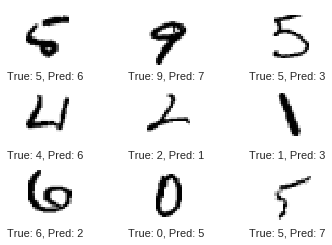

In [1030]:
print_test_accuracy(show_example_errors=True)

## Performanța după 1000 de iterații

După 1000 de iterații, modelul și-a îmbunătățit semnificativ acuratețea pe setul de test, depășind 90%.

In [1031]:
optimize(num_iterations=900) # We performed 100 iterations above.

Iter:    101, Training Accuracy:  87.5%
Iter:    201, Training Accuracy:  89.1%
Iter:    301, Training Accuracy:  92.2%
Iter:    401, Training Accuracy:  85.9%
Iter:    501, Training Accuracy:  90.6%
Iter:    601, Training Accuracy:  85.9%
Iter:    701, Training Accuracy:  98.4%
Iter:    801, Training Accuracy:  93.8%
Iter:    901, Training Accuracy:  93.8%
Time: 0:00:07


Accuracy on Test-Set: 95.3% (9534 / 10000)
Example errors:


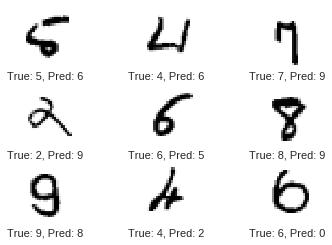

In [1032]:
print_test_accuracy(show_example_errors=True)

## Performanța după 10,000 de iterații

După 10,000 de iterații, acuratețea modelului se apropie de 99%.

In [1033]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Iter:   1001, Training Accuracy:  95.3%
Iter:   1101, Training Accuracy:  90.6%
Iter:   1201, Training Accuracy:  96.9%
Iter:   1301, Training Accuracy:  98.4%
Iter:   1401, Training Accuracy:  93.8%
Iter:   1501, Training Accuracy:  96.9%
Iter:   1601, Training Accuracy:  96.9%
Iter:   1701, Training Accuracy:  96.9%
Iter:   1801, Training Accuracy:  93.8%
Iter:   1901, Training Accuracy:  96.9%
Iter:   2001, Training Accuracy:  93.8%
Iter:   2101, Training Accuracy:  98.4%
Iter:   2201, Training Accuracy:  96.9%
Iter:   2301, Training Accuracy: 100.0%
Iter:   2401, Training Accuracy:  98.4%
Iter:   2501, Training Accuracy: 100.0%
Iter:   2601, Training Accuracy:  98.4%
Iter:   2701, Training Accuracy:  98.4%
Iter:   2801, Training Accuracy:  96.9%
Iter:   2901, Training Accuracy:  98.4%
Iter:   3001, Training Accuracy:  98.4%
Iter:   3101, Training Accuracy:  98.4%
Iter:   3201, Training Accuracy:  98.4%
Iter:   3301, Training Accuracy: 100.0%
Iter:   3401, Training Accuracy:  96.9%


Accuracy on Test-Set: 98.8% (9883 / 10000)
Example errors:


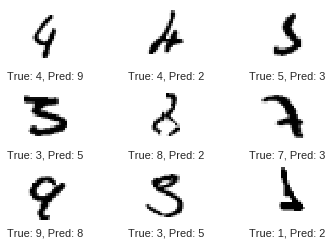

Confusion Matrix:
[[ 969    0    2    1    0    1    3    0    4    0]
 [   0 1130    2    0    0    0    2    1    0    0]
 [   1    1 1024    1    1    0    0    2    2    0]
 [   0    0    2  995    0    6    0    1    2    4]
 [   0    0    1    0  973    0    3    0    0    5]
 [   1    0    0    5    0  883    2    0    1    0]
 [   3    2    0    1    3    4  944    0    1    0]
 [   0    3    6    1    1    0    0 1014    1    2]
 [   2    0    1    3    0    1    1    2  962    2]
 [   0    2    0    1    7    4    0    2    4  989]]


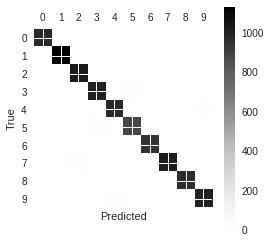

In [1034]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

## Vizualizarea ponderilor și a straturilor

Pentru a înțelege de ce rețeaua neurală convoluțională poate recunoaște cifrele scrise de mână, vom vizualiza ponderile filtrelor convoluționale și imaginile rezultate.

### Funcție ajutătoare pentru afișarea ponderilor

In [0]:
def plot_conv_weights(weights, input_channel=0):
    # Obține valorile ponderiloe
    w = session.run(weights)

    # Obține valorile minimă și maximă.
    w_min = np.min(w)
    w_max = np.max(w)

    # Numărul de filtre în stratul convoluțional.
    num_filters = w.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    # Afișează toate filtrele.
    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = w[:, :, input_channel, i]

            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Funcție ajutătoare pentru afișarea rezultatului convoluțiilor

In [0]:
def plot_conv_layer(layer, image):
    feed_dict = {x: [image]}

    # Calculează rezultatul convoluțiilor pentru imaginea dată.
    values = session.run(layer, feed_dict=feed_dict)

    # Numărul de filtre.
    num_filters = values.shape[3]

    num_grids = math.ceil(math.sqrt(num_filters))
    
    fig, axes = plt.subplots(num_grids, num_grids)

    for i, ax in enumerate(axes.flat):
        if i<num_filters:
            img = values[0, :, :, i]

            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.show()

### Imaginile de input

Funcție ajutătoare pentru afișarea unei imagini.

In [0]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

Afișează o imagine din setul de test ce va fi folosită ca exemplu.

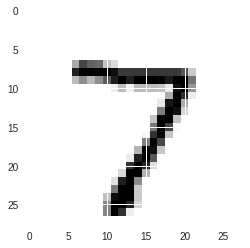

In [67]:
image1 = x_test[0]
plot_image(image1)

Afișează o altă imagine din setul de test.

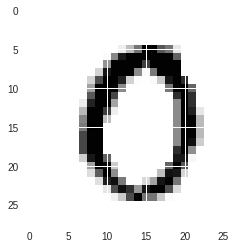

In [68]:
image2 = x_test[13]
plot_image(image2)

### Primul strat convoluțional

Afișează ponderile primului strat convoluțional.

Rețineți că ponderile pozitive sunt cele roșii, iar ponderile negative sunt cele albastre.

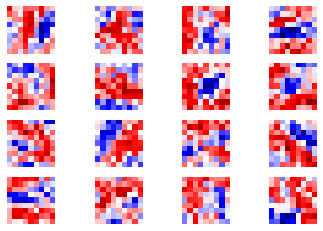

In [366]:
plot_conv_weights(weights=weights_conv1)

Aplicând fiecare filtru pe prima imagine de input, obținem următoarele rezultate, care sunt după aceea folosite ca input în cel de-al 2-lea strat convoluțional.

Observați că inputul în cel de-al 2-lea strat convoluțional este micșorat la 14x14 pixeli, jumătate din rezoluția imaginii originale.

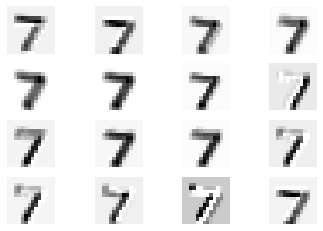

In [70]:
plot_conv_layer(layer=layer_conv1, image=image1)

Imaginile de mai jos sunt rezultatele aplicării filtrelor pe cea de-a 2-a imagine.

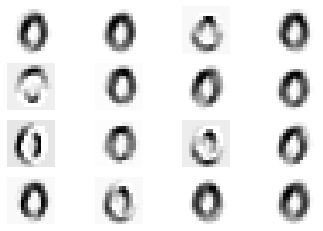

In [210]:
plot_conv_layer(layer=layer_conv1, image=image2)

Este dificil de observat din aceste imagini care ar putea fi rolul filtrelor convoluționale. Se pare că au creat doar câteva variații ale imaginii de input, ca și cum lumina se reflectă sub unghiuri diferite.

### Cel de-al 2-lea strat convoluțional

Afișăm ponderile celui de-al 2-lea strat convoluțional.

Sunt 16 canale în urma primului filtru convoluțional, ceea ce înseamnă că sunt 16 canale în inputul celui de-al 2-lea strat convoluțional. Acesta conține un set de filtre pentru fiecare canal din input. Începem prin afișarea poderilor pentru primul canal.

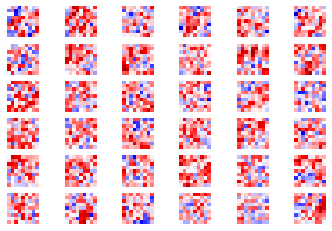

In [367]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

Afișăm ponderile și pentru cel de-al 2-lea canal din input.

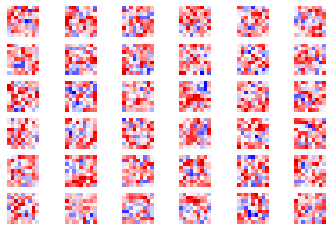

In [368]:
plot_conv_weights(weights=weights_conv2, input_channel=1)

Poate fi dificil de înțeles și de urmărit modul în care sunt aplicate aceste filtre datoriră dimensionalității ridicate.

Aplicând aceste filtre imaginilor rezultate în urma primului strat convoluțional, obținem următoarele imagini.

Observați că acestea sunt micșorate la 7x7 pixeli, jumătate din rezoluția imaginilor din primul strat convoluțional.

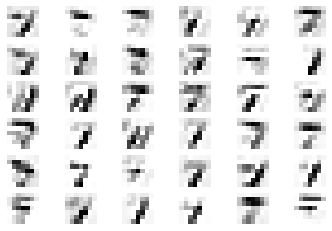

In [74]:
plot_conv_layer(layer=layer_conv2, image=image1)

Acestea sunt rezultatele aplicării filtrelor pe cea de-a 2-a imagine.

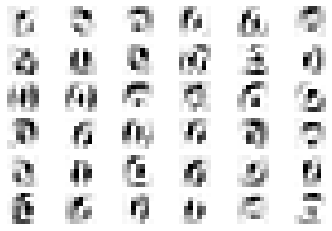

In [75]:
plot_conv_layer(layer=layer_conv2, image=image2)

Din aceste imagini se pare că cel de-al 2-lea strat convoluțional ar putea detecta linii și modele în imaginile de input, care sunt mai puțin sensibile la variațiile locale ale imaginilor de input.

### Închide sesiunea TensorFlow

Închidem sesiunea TensorFlow pentru a elibera resursele.

In [0]:
session.close()

## Concluzie

Am văzut că o Rețea Neurală Convoluțională funcționează mult mai bine la recunoaștere cifrelor scrise de mână decât modelul liniar simplu din primul laborator. Rețeaua Convoluțională obține o acuratețe de clasificare de aproximativ 99%, sau chiar mai mult dacă se fac unele ajustări, comparativ cu doar 91% în cazul modelului liniar simplu.

Cu toate acestea, Rețeaua Convoluțională este mult mai greu de implementat și nu este evident din analiza ponderilor de ce funcționează și de ce uneori eșuează.

## Exerciții

* Obțineți exact aceleași rezultate dacă rulați de mai multe ori, fără a schimba vreun parametru? Care sunt sursele care ar putea explica comportamentul aleatoriu?
* Rulați încă 10,000 de iterații de optimizare. Sunt rezultatele mai bune?
* Schimbați rate de învățare a optimizatorului.
* Schimbați configurația straturilor, precum numărul de filtre convoluționale, dimensiunea acestor filtre, numărul de neuroni în stratul fully-connected.
* Schimbați ordinea operațiilor ReLU și max-pooling în stratul convoluțional. Se calculează același lucru? Funcționează și pentru sigmoid și avg-pooling?
* Adaugați încă unul sau mai multe straturi convoluționale și fully-connected. Se îmbunătățește performanța?
* Care este cea mai mică configurație posibilă care încă obține rezultate bune?
* Încercați să aplicați ReLU după ultimul strat fully-connected. Se schimbă performanța modelului? De ce?
* Încercați să renunțați la pooling în straturile convoluționale. Se modifică acuratețea și timpul de antrenare?
* Încercați să folosiți stride 2x2 în convoluție, renunțând la max-pooling. Care este diferența?
* Rescrieți programul fără a vă uita prea mult la acest exemplu.

---

* Comportamentul aleatoriu este dat de alegerea unui batch random din setul de antrenare.
* Dupa inca 10.000 iteratii acuratetea creste foarte putin, dar nu este garantata cresterea continua deoarece modelul invata din date pe care le-a mai vazut.
* Cu un learning_rate mai mare(=1e-2 ),  optimizatorul nu reuseste sa ajunga la valoare minima a functiei de cost, prin urmare acuratetea scade. Daca learning_rate este 1e-6 atunci convergenta se observa dupa mai multe iteratii, daca setam learning_rate mai mic atunci nici nu se observa convergenta in doar 10.000 iteratii.


In [0]:
filter_size1 = 7          
num_filters1 = 8         

filter_size2 = 7          
num_filters2 = 16         

fc_size = 64   
#Acc = 98.6% Obs. se pare ca acum confunda des 9 cu celelalte cifre
# rez similare cu filter_size 9 si cu dublarea nr de filtre si a stratul fully-connected

* Cand schimbam ordinea ReLU si max-pooling obtinem rezultate asemanatoare. Cand folosim avg_pooling si sigmoid obtinem o acuratete mai mica de 94.6%, iar daca schimbam ordinea obtinem eroare.


In [0]:
# Cu urmatoarea config am obtinut o acuratete de 98.5% deci o performanta asemanatoare.

# Primul strat convoluțional.
filter_size1 = 5          
num_filters1 = 16         
# Al 2-lea strat convoluțional.
filter_size2 = 5         
num_filters2 = 36         
#Al 3-lea strat conv.
filter_size3 = 5         
num_filters3 = 64  

# Stratul fully-connected.
fc_size = 128            
# Stratul fully-connected extra.
fc_size2 = 64

* Renuntant la al 2-lea hidden layer am obtinut o acuratete de 98.2% si intr un timp mai mic.
* Aplicand ReLU pe ultimul strat fully-connected obs o scadere mare in acuratete la 79%,
* Renuntand la max-pooling nu se obs scadere in acuratete dar creste timpul.


